In [2]:
import numpy as np  # для матричных вычислений
import pandas as pd  # для анализа и предобработки данных
import matplotlib.pyplot as plt  # для визуализации
import seaborn as sns  # для визуализации

from sklearn import metrics  # метрики
from sklearn import model_selection  # методы разделения и валидации
from sklearn import linear_model  # линейные модели
from sklearn import tree  # деревья решений
plt.style.use('seaborn')  # стиль отрисовки seaborn
%matplotlib inline


/var/folders/1_/hgb3xg852md0hqqs3ybwbsp40000gn/T/ipykernel_22263/1336932142.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # стиль отрисовки seaborn


In [3]:
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
# Информация о пропусках в процентах
display(water_data.isnull().mean() * 100)


ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [5]:
# Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(
    water_data.groupby('Potability')['ph'].transform('median'))

water_data['Sulfate'] = water_data['Sulfate'].fillna(
    water_data.groupby('Potability')['Sulfate'].transform('median'))

water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(
    water_data.groupby('Potability')['Trihalomethanes'].transform('median'))


In [6]:
display(water_data.isnull().mean() * 100)


ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

---

### Двухкомпонентный подход

In [7]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']


In [8]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42)


In [9]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))


Train shape: (2620, 9)
Valid shape: (656, 9)


In [10]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy',  # критерий информативности
    max_depth=7,  # максимальная глубина
    min_samples_leaf=5,  # минимальное число объектов в листе
    random_state=42  # генератор случайных чисел
)

# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик
print(
    'Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print(
    'Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))


Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


---

### Трехкомпонентный подход

In [11]:
# разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42)

# разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(
    X_valid, y_valid, test_size=0.5, random_state=42)


In [12]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))


Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


---

### K-fold (кросс- валидация)

In [13]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy',  # критерий информативности
    max_depth=7,  # максимальная глубина
    min_samples_leaf=5,  # минимальное число объектов в листе
    random_state=42  # генератор случайных чисел
)

# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)

# Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []

# Организуем цикл для кросс-валидации (используем весь набор данных)
# train_index — индексы тренировочной выборки
# valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y):

    # Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

    # Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)

    # Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    # Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))


In [14]:
print(train_metrics)
print(val_metrics)


[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


In [15]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))


Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


### или

In [16]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy',  # критерий информативности
    max_depth=7,  # максимальная глубина
    min_samples_leaf=5,  # минимальное число объектов в листе
    random_state=42  # генератор случайных чисел
)

# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)

# Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model,  # модель
    X=X,  # матрица наблюдений X
    y=y,  # вектор ответов y
    cv=kf,  # кросс-валидатор
    scoring='accuracy',  # метрика
    return_train_score=True  # подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)


{'fit_time': array([0.02448201, 0.02394509, 0.0232029 , 0.02277303, 0.02326512]),
 'score_time': array([0.00139117, 0.00111079, 0.00101089, 0.00099373, 0.00098205]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [17]:
print(
    'Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print(
    'Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))


Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


---

### Leave-one-out

In [18]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy',  # критерий информативности
    max_depth=7,  # максимальная глубина
    min_samples_leaf=5,  # минимальное число объектов в листе
    random_state=42  # генератор случайных чисел
)

# Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()

# Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model,  # модель
    X=X.iloc[:500],  # матрица наблюдений X
    y=y.iloc[:500],  # вектор ответов y
    cv=loo,  # кросс-валидатор
    scoring='accuracy',  # метрика
    return_train_score=True  # подсчёт метрики на тренировочных фолдах
)

print(
    'Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print(
    'Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))


Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


---

### СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

In [19]:
# Обычное разбиение, с расбалансом распределения по классам в тренировочной и валидационной выборках
X, y = water_data.drop('Potability', axis=1), water_data['Potability']

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=1)

print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')


Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


In [20]:
# Стратифицированное разьмение
X, y = water_data.drop('Potability', axis=1), water_data['Potability']

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')


Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


___

### Стратификация k-fold

In [21]:
skf = model_selection.StratifiedKFold(
    n_splits=3, shuffle=True, random_state=42)

for train_index, valid_index in skf.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)


Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


___

### Task 3.3
Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам

Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении 80/20. В качестве значения параметра random_state возьмите число 42.

Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

<AxesSubplot: xlabel='feature_1', ylabel='feature_2'>

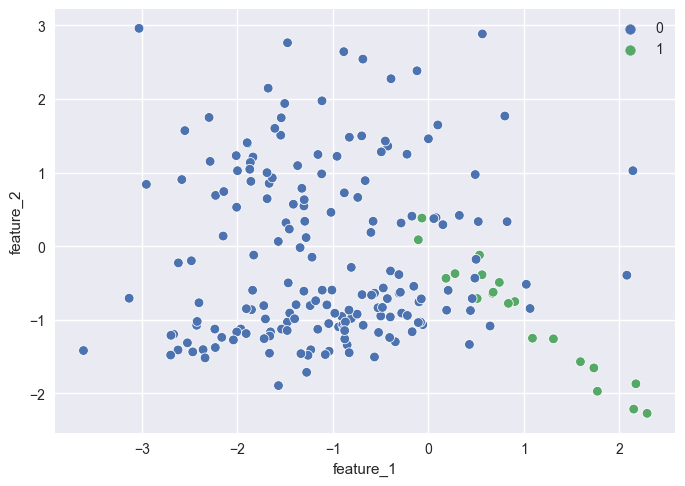

In [22]:
from sklearn import datasets

X_task, y_task = datasets.make_classification(
    n_samples=200,  # количество объектов
    n_features=2,  # количество признаков
    n_informative=2,  # количество информативных признаков
    n_redundant=0,  # количество неинформативных признаков
    n_classes=2,  # количество классов
    weights=[1, 0.2],  # пропорции классов
    random_state=40  # генератор случайных чисел
)

X_task = pd.DataFrame(X_task, columns=['feature_1', 'feature_2'])

y_task = pd.Series(y_task)
sns.scatterplot(x=X_task['feature_1'], y=X_task['feature_2'], hue=y_task)


### Answer%

<AxesSubplot: xlabel='feature_1', ylabel='feature_2'>

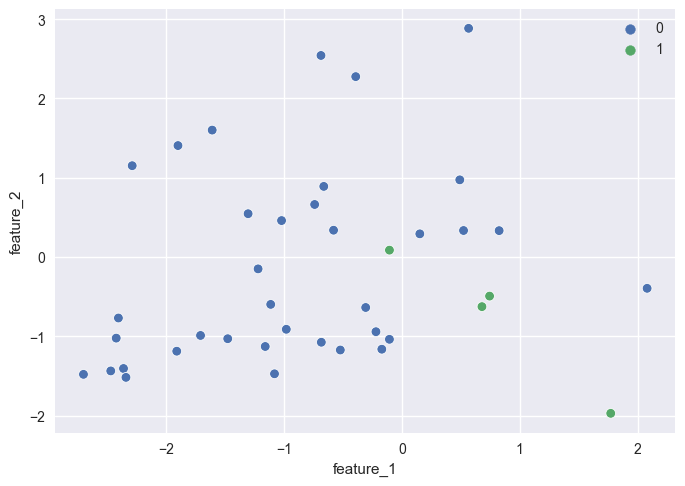

In [23]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_task, y_task, stratify=y_task, test_size=0.2, random_state=42)

sns.scatterplot(
    x=X_valid['feature_1'],
    y=X_valid['feature_2'],
    hue=y_task)


___

### ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

In [24]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



---

### Task 3.5
Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Обучите модель логистической регрессии на тренировочной выборке (все параметры оставьте по умолчанию).
Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-
разделителя.

In [25]:
X_task, y_task = datasets.make_classification(
    n_samples=200,  # количество объектов
    n_features=2,  # количество признаков
    n_informative=2,  # количество информативных признаков
    n_redundant=0,  # количество неинформативных признаков
    n_classes=2,  # количество классов
    weights=[1, 0.2],  # пропорции классов
    random_state=40  # генератор случайных чисел
)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_task, y_task, stratify=y_task, test_size=0.2, random_state=42)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

y_valid_pred = model.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



---

### ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

#### ВЗВЕШИВАНИЕ ОБЪЕКТОВ

In [26]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy',  # критерий информативности
    max_depth=7,  # максимальная глубина
    min_samples_leaf=5,  # минимальное число объектов в листе
    random_state=42,  # генератор случайных чисел
    class_weight='balanced'  # веса классов
)

# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))


              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



---

### Task 3.7
Обучите модель логистической регрессии на тренировочной выборке, установив сбалансированные веса для классов.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [27]:
X_task, y_task = datasets.make_classification(
    n_samples=200,  # количество объектов
    n_features=2,  # количество признаков
    n_informative=2,  # количество информативных признаков
    n_redundant=0,  # количество неинформативных признаков
    n_classes=2,  # количество классов
    weights=[1, 0.2],  # пропорции классов
    random_state=40  # генератор случайных чисел
)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_task, y_task, stratify=y_task, random_state=42)

model = linear_model.LogisticRegression(
    class_weight='balanced'
)

model.fit(X_train, y_train)

y_valid_pred = model.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred))


              precision    recall  f1-score   support

           0       0.97      0.84      0.90        45
           1       0.36      0.80      0.50         5

    accuracy                           0.84        50
   macro avg       0.67      0.82      0.70        50
weighted avg       0.91      0.84      0.86        50



---

#### ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

In [28]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)

#Обучаем модель
model.fit(X_train, y_train)

#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [29]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [30]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.33333333 0.4        0.5        0.55555556]
Precision scores: [0.1        0.44       0.5        0.6875     0.64285714]
Recall scores: [1.         0.73333333 0.73333333 0.73333333 0.6       ]


Best threshold = 0.50, F1-Score = 0.71


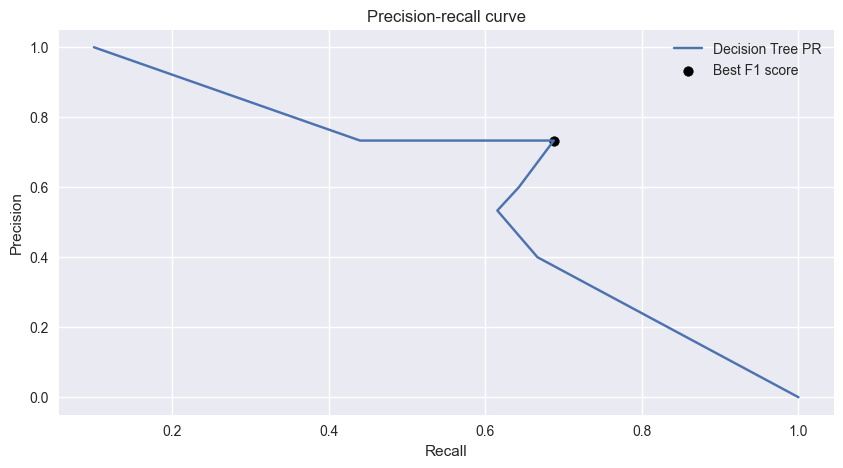

In [31]:
# Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)

# Определяем индекс максимума
idx = np.argmax(f1_scores)
print(
    'Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5))  # фигура + координатная плоскость

# Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')

# Отмечаем точку максимума F1
ax.scatter(
    precision[idx], recall[idx], marker='o', 
    color='black', label='Best F1 score')

# Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

# Отображаем легенду
ax.legend()


In [32]:
threshold_opt = thresholds[idx]

# Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
# В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')

# Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96        45
           1       0.60      0.60      0.60         5

    accuracy                           0.92        50
   macro avg       0.78      0.78      0.78        50
weighted avg       0.92      0.92      0.92        50



Примечание. Чтобы вычислить площадь под PR-кривой, используется функция аис() из модуля metrics библиотеки sklearn. В данную
функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

In [33]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.62


---

#### СЭМПЛИРОВАНИЕ

In [34]:
from imblearn.over_sampling import SMOTE

In [35]:
# Проведем инициализацию дата-сета заново, т.к. в процессе обучения сет перебило
water_data = pd.read_csv('data/water_potability.csv')

# Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(
    water_data.groupby('Potability')['ph'].transform('median'))

water_data['Sulfate'] = water_data['Sulfate'].fillna(
    water_data.groupby('Potability')['Sulfate'].transform('median'))

water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(
    water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

# Стратифицированное разбмение
X, y = water_data.drop('Potability', axis=1), water_data['Potability']

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)


In [36]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    1598
1    1022
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    1598
1    1598
Name: Potability, dtype: int64


In [37]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy',  # критерий информативности
    max_depth=7,  # максимальная глубина
    min_samples_leaf=5,  # минимальное число объектов в листе
    random_state=42,  # генератор случайных чисел
)

# Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))


              precision    recall  f1-score   support

           0       0.82      0.66      0.73       400
           1       0.59      0.77      0.67       256

    accuracy                           0.70       656
   macro avg       0.70      0.71      0.70       656
weighted avg       0.73      0.70      0.70       656



---

### Task 3.11
Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Сбалансируйте тренировочную выборку с помощью алгоритма SMOTE. В качестве значения параметра random state возьмите число 42,
остальные параметры оставьте по умолчанию.

Обучите модель логистической регрессии на пересэмплированной тренировочной выборке. Все параметры оставьте по умолчанию.
Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-
разделителя.

In [38]:
from sklearn import datasets

X_task, y_task = datasets.make_classification(
    n_samples=200,  # количество объектов
    n_features=2,  # количество признаков
    n_informative=2,  # количество информативных признаков
    n_redundant=0,  # количество неинформативных признаков
    n_classes=2,  # количество классов
    weights=[1, 0.2],  # пропорции классов
    random_state=40  # генератор случайных чисел
)

X_task = pd.DataFrame(X_task, columns=['feature_1', 'feature_2'])

y_task = pd.Series(y_task)


In [39]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_task, y_task, test_size=0.2, stratify=y_task, random_state=42)

sm = SMOTE(random_state=42)

X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

model = linear_model.LogisticRegression()
model.fit(X_train_s, y_train_s)

y_valid_pred = model.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred))


              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



---